## Gathering Dependencies

_Importing Required Libraries_

In [1]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
from numpy import array

## Pretraining

_Lienard intermittancy_

The `lienard_intermittency.dat` is generated from the Runge Kutta Method.

This feeds the model with the dynamics of the Lienard System

In [3]:
data = np.genfromtxt('datasets/lienard_intermittency.dat')
training_set = pd.DataFrame(data).reset_index(drop=True)
training_set = training_set.iloc[:,1]

## Computing the Gradients

_Calculating the value of_ $\frac{dx}{dt}$, _and_ $\frac{d^2x}{dt^2}$

In [4]:
t_diff = 7 # Weekly Data
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:]
print(gradient_t)
gradient_tt = (gradient_t.diff()/t_diff).iloc[1:]
print(gradient_tt)

1.00123132
1         7.142857e-07
2         1.421429e-06
3         2.124286e-06
4         2.810000e-06
5         3.481429e-06
              ...     
139867    0.000000e+00
139868    0.000000e+00
139869    0.000000e+00
139870    0.000000e+00
139871    0.000000e+00
Name: 1, Length: 139871, dtype: float64
2         1.010204e-07
3         1.004082e-07
4         9.795918e-08
5         9.591837e-08
6         9.244898e-08
              ...     
139867    0.000000e+00
139868    0.000000e+00
139869    0.000000e+00
139870    0.000000e+00
139871    0.000000e+00
Name: 1, Length: 139870, dtype: float64


## Loading Datasets

_SAN JUAN_

In [5]:
data = pd.read_csv("datasets/sanjuan.csv")
training_set = data.iloc[:, 3]
print(training_set)

0        4
1        5
2        4
3        3
4        6
        ..
1191    56
1192    46
1193    52
1194    34
1195    25
Name: Cases, Length: 1196, dtype: int64


In [6]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
gradient_tt = gradient_tt.reset_index(drop=True)
print(gradient_t)
print(gradient_tt)

0         7.142857e-07
1         1.421429e-06
2         2.124286e-06
3         2.810000e-06
4         3.481429e-06
              ...     
139866    0.000000e+00
139867    0.000000e+00
139868    0.000000e+00
139869    0.000000e+00
139870    0.000000e+00
Name: 1, Length: 139871, dtype: float64
0         1.010204e-07
1         1.004082e-07
2         9.795918e-08
3         9.591837e-08
4         9.244898e-08
              ...     
139865    0.000000e+00
139866    0.000000e+00
139867    0.000000e+00
139868    0.000000e+00
139869    0.000000e+00
Name: 1, Length: 139870, dtype: float64


In [7]:
print(gradient_t.shape)
print(training_set.shape[:-1])
df = pd.concat((training_set[:-1], gradient_t), axis=1)
gradient_tt.columns = ["grad_tt"]
df = pd.concat((df[:-1], gradient_tt), axis=1)
df.columns = ['y_t', 'grad_t', 'grad_tt']

(139871,)
()


## Preprocessing the data into supervised learning

In [8]:
def Supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
       agg.dropna(inplace=True)
    return agg    

In [9]:
dat = Supervised(df.values, n_in = 10, n_out = 13)
dat.columns

Index(['var1(t-10)', 'var2(t-10)', 'var3(t-10)', 'var1(t-9)', 'var2(t-9)',
       'var3(t-9)', 'var1(t-8)', 'var2(t-8)', 'var3(t-8)', 'var1(t-7)',
       'var2(t-7)', 'var3(t-7)', 'var1(t-6)', 'var2(t-6)', 'var3(t-6)',
       'var1(t-5)', 'var2(t-5)', 'var3(t-5)', 'var1(t-4)', 'var2(t-4)',
       'var3(t-4)', 'var1(t-3)', 'var2(t-3)', 'var3(t-3)', 'var1(t-2)',
       'var2(t-2)', 'var3(t-2)', 'var1(t-1)', 'var2(t-1)', 'var3(t-1)',
       'var1(t)', 'var2(t)', 'var3(t)', 'var1(t+1)', 'var2(t+1)', 'var3(t+1)',
       'var1(t+2)', 'var2(t+2)', 'var3(t+2)', 'var1(t+3)', 'var2(t+3)',
       'var3(t+3)', 'var1(t+4)', 'var2(t+4)', 'var3(t+4)', 'var1(t+5)',
       'var2(t+5)', 'var3(t+5)', 'var1(t+6)', 'var2(t+6)', 'var3(t+6)',
       'var1(t+7)', 'var2(t+7)', 'var3(t+7)', 'var1(t+8)', 'var2(t+8)',
       'var3(t+8)', 'var1(t+9)', 'var2(t+9)', 'var3(t+9)', 'var1(t+10)',
       'var2(t+10)', 'var3(t+10)', 'var1(t+11)', 'var2(t+11)', 'var3(t+11)',
       'var1(t+12)', 'var2(t+12)', 'var3(t+12)']

In [10]:
data = Supervised(df.values, n_in = 10, n_out = 13)
data.drop(['var2(t-10)', 'var3(t-10)', 'var2(t-9)', 'var3(t-9)', 'var2(t-8)',
       'var3(t-8)', 'var2(t-7)', 'var3(t-7)', 'var2(t-6)', 'var3(t-6)',
       'var2(t-5)', 'var3(t-5)', 'var2(t-4)', 'var3(t-4)', 'var2(t-2)',
       'var3(t-2)', 'var2(t-1)', 'var3(t-1)','var2(t-3)', 'var3(t-3)'], axis = 1, inplace = True)#,18,19
print(data.head())
print(data.columns)

    var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  \
10         4.0        5.0        4.0        3.0        6.0        2.0   
11         5.0        4.0        3.0        6.0        2.0        4.0   
12         4.0        3.0        6.0        2.0        4.0        5.0   
13         3.0        6.0        2.0        4.0        5.0       10.0   
14         6.0        2.0        4.0        5.0       10.0        6.0   

    var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  ...     var3(t+9)  var1(t+10)  \
10        4.0        5.0       10.0        6.0  ... -2.877551e-08        40.0   
11        5.0       10.0        6.0        8.0  ... -4.142857e-08        27.0   
12       10.0        6.0        8.0        2.0  ... -5.510204e-08        42.0   
13        6.0        8.0        2.0        6.0  ... -6.918367e-08        33.0   
14        8.0        2.0        6.0       17.0  ... -8.408163e-08        43.0   

    var2(t+10)    var3(t+10)  var1(t+11)  var2(t+11)    var3(t+11)  \
10  

## Train and Test Split

In [11]:
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train_1 = np.array(data[0:train_size])
test_1 = np.array(data[train_size:len(data)])
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train_1)
test = scaler.transform(test_1)
trainY = train[:,-9:]
trainX = train[:,:-9]
testY = test[:,-9:]
testX = test[:,:-9]
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(938, 1, 40) (938, 9) (235, 1, 40) (235, 9)


## Model

In [12]:
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(9))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=500, batch_size=64, validation_data=(testX, testY), shuffle=False)

Epoch 1/500
15/15 [==============================] - 2s 39ms/step - loss: 0.1960 - val_loss: 0.1147
Epoch 2/500
15/15 [==============================] - 0s 4ms/step - loss: 0.0722 - val_loss: 0.0205
Epoch 3/500
15/15 [==============================] - 0s 5ms/step - loss: 0.0240 - val_loss: 0.0132
Epoch 4/500
15/15 [==============================] - 0s 4ms/step - loss: 0.0205 - val_loss: 0.0112
Epoch 5/500
15/15 [==============================] - 0s 5ms/step - loss: 0.0173 - val_loss: 0.0081
Epoch 6/500
15/15 [==============================] - 0s 4ms/step - loss: 0.0146 - val_loss: 0.0074
Epoch 7/500
15/15 [==============================] - 0s 5ms/step - loss: 0.0123 - val_loss: 0.0068
Epoch 8/500
15/15 [==============================] - 0s 5ms/step - loss: 0.0104 - val_loss: 0.0062
Epoch 9/500
15/15 [==============================] - 0s 4ms/step - loss: 0.0087 - val_loss: 0.0056
Epoch 10/500
15/15 [==============================] - 0s 4ms/step - loss: 0.0072 - val_loss: 0.0051
Epoch 11

## Metrics

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
yhat = model.predict(testX)
print(yhat.shape)
testX = testX.reshape((testX.shape[0], testX.shape[2]))
print(testX.shape)
inv_yhat = np.concatenate((testX, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat1 = inv_yhat[:, -3:]
inv_yhat = inv_yhat[:, -3]
inv_y = np.concatenate((testX, testY), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y1 = inv_y[:, -3:]
inv_y = inv_y[:, -3]
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

8/8 [==============================] - 0s 2ms/step
(235, 9)
(235, 40)
Test RMSE: 32.409
Test MAE: 20.581


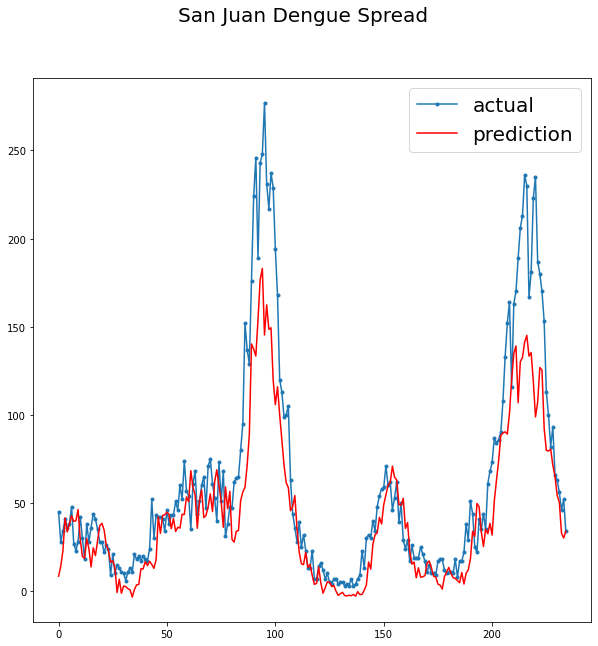

In [14]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(inv_y, marker='.', label="actual")
plt.plot(inv_yhat, 'r', label="prediction")
plt.suptitle('San Juan Dengue Spread', fontsize=20)
plt.legend(fontsize=20)
plt.show()